# Обучение нейрона с помощью функции потерь LogLoss

<h3 style="text-align: center;"><b>Нейрон с сигмоидой</b></h3>

Снова рассмотрим нейрон с сигмоидой, то есть $$f(x) = \sigma(x)=\frac{1}{1+e^{-x}}$$ 

Ранее мы установили, что **обучение нейрона с сигмоидой с квадратичной функцией потерь**:  

$$MSE(w, x) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (\sigma(w \cdot x_i) - y_i)^2$$    

где $w \cdot x_i$ - скалярное произведение, а $\sigma(w \cdot x_i) =\frac{1}{1+e^{-w \cdot x_i}} $ - сигмоида -- **неэффективно**, то есть мы увидели, что даже за большое количество итераций нейрон предсказывает плохо.

Давайте ещё раз взглянем на формулу для градиентного спуска от функции потерь $MSE$ по весам нейрона:

$$ \frac{\partial MSE}{\partial w} = \frac{1}{n} X^T (\sigma(w \cdot X) - y)\sigma(w \cdot X)(1 - \sigma(w \cdot X))$$

А теперь смотрим на график сигмоиды:

<img src="https://cdn-images-1.medium.com/max/1200/1*IDAnCFoeXqWL7F4u9MJMtA.png" width=500px height=350px>

**Её значения: числа от 0 до 1.**

Если получше проанализировать формулу, то теперь можно заметить, что, поскольку сигмоида принимает значения между 0 и 1 (а значит (1-$\sigma$) тоже принимает значения от 0 до 1), то мы умножаем $X^T$ на столбец $(\sigma(w \cdot X) - y)$ из чисел от -1 до 1, а потом ещё на столбцы $\sigma(w \cdot X)$ и $(1 - \sigma(w \cdot X))$ из чисел от 0 до 1. Таким образом в лучшем случае $\frac{\partial{Loss}}{\partial{w}}$ будет столбцом из чисел, порядок которых максимум 0.01 (в среднем, понятно, что если сигмоида выдаёт все 0, то будет 0, если все 1, то тоже 0). После этого мы умножаем на шаг градиентного спуска, который обычно порядка 0.001 или 0.1 максимум. То есть мы вычитаем из весов числа порядка ~0.0001. Медленновато спускаемся, не правда ли? Это называют **проблемой затухающих градиентов**.

Чтобы избежать эту проблему в задачах классификации, в которых моделью является нейрон с сигмоидной функцией активации, предсказывающий "вероятности" принадлженостей к классам используют **LogLoss**:  

$$J(\hat{y}, y) = -\frac{1}{n} \sum_{i=1}^n y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i}) = -\frac{1}{n} \sum_{i=1}^n y_i \log(\sigma(w \cdot x_i)) + (1 - y_i) \log(1 - \sigma(w \cdot x_i))$$

где, как и прежде, $y$ - столбец $(n, 1)$ из истинных значений классов, а $\hat{y}$ - столбец $(n, 1)$ из предсказаний нейрона.

Отметим, что сейчас речь идёт именно о **бинарной классификации (на два класса)**, в многоклассовой классификации используется функция потерь под названием *кросс-энтропия*, которая является обобщением LogLoss'а на случай нескольких классов.

Почему же теперь всё будет лучше? Раньше была проблема умножения маленьких чисел в градиенте. Давайте посмотрим, что теперь:

* Для веса $w_j$:

$$ \frac{\partial Loss}{\partial w_j} = 
-\frac{1}{n} \sum_{i=1}^n \left(\frac{y_i}{\sigma(w \cdot x_i)} - \frac{1 - y_i}{1 - \sigma(w \cdot x_i)}\right)(\sigma(w \cdot x_i))_{w_j}' = -\frac{1}{n} \sum_{i=1}^n \left(\frac{y_i}{\sigma(w \cdot x_i)} - \frac{1 - y_i}{1 - \sigma(w \cdot x_i)}\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{ij} = $$
$$-\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{ij}$$

* Градиент $Loss$'а по вектору весов -- это вектор, $j$-ая компонента которого равна $\frac{\partial Loss}{\partial w_j}$ (помним, что весов всего $m$):

$$\begin{align}
    \frac{\partial Loss}{\partial w} &= \begin{bmatrix}
           -\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{i1} \\
           -\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{i2} \\
           \vdots \\
           -\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{im}
         \end{bmatrix}
\end{align}=\frac{1}{n} X^T \left(\hat{y} - y\right)$$

По аналогии с $w_j$ выведите формулу для свободного члена (bias'а) $b$ (*hint*: можно считать, что при нём есть признак $x_{i0}=1$ на всех $i$).

Получили новое правило для обновления $w$ и $b$. 

In [1]:
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def loss(y_pred, y):
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

In [3]:
def sigmoid(x):
    """Сигмоидальная функция"""
    return 1 / (1 + np.exp(-x))

Реализуйте нейрон с функцией потерь LogLoss:

In [32]:
class Neuron:
    def __init__(self, *,
                 w: np.array = None,
                 b: float = 0,
                 learning_rate: float = 0.1,
                 activation_function: callable = sigmoid,
                 epoch_number: int = 5000):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        :param: learning_rate -- скорость обучения
        :param: activation_function -- функция активации
        :param: epoch_number -- количество итераций обучения
        """
        self._w = w
        self._b = b
        self._learning_rate = learning_rate
        self._activation_function = activation_function
        self._epoch_number = epoch_number

    def predict(self, x_test: np.array, threshold: float) -> np.array:
        """
        Предсказание ответов
        :param: x_test -- матрица объектов размера (n, m)
        :param: threshold -- пороговое значение для классификации
        :return: y_pred -- вектор предсказанных ответов размера (n, 1)
        """
        return (self._forward_pass(x_test) > threshold).astype(int)


    def fit(self, x: np.array, y: np.array) -> np.array:
        """
        Спускаемся в минимум
        :param: x -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
        :return: J_values -- вектор значений функции потерь
        """
        self._w = np.zeros((x.shape[1], 1))  # столбец (m, 1)
        self._b = 0  # смещение
        loss_values = np.array([])  # значения функции потерь на различных итерациях обновления весов

        for i in range(self._epoch_number):
            # предсказания с текущими весами
            y_pred = self._forward_pass(x)
            # считаем функцию потерь с текущими весами
            loss_values = np.append(loss_values, loss(y_pred, y))
            # обновляем веса по формуле градиентного спуска
            self._backward_pass(x, y, y_pred)

        return loss_values

    def _forward_pass(self, x: np.array) -> np.array:
        """
        Эта функция рассчитывает ответ нейрона при предъявлении набора объектов
        :param: x -- матрица объектов размера (n, m), каждая строка - объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами перцептрона
        """
        return self._activation_function(x @ self._w + self._b)

    def _backward_pass(self, x: np.array, y: np.array, y_pred: np.array) -> None:
        """
        Обновляет значения весов нейрона в соответствие с этим объектом
        :param: x -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                y_pred -- вектор предсказаний размера (n, 1)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        self._w -= self._learning_rate * x.T @ (y_pred - y) / x.shape[0]
        self._b -= self._learning_rate * np.mean(y_pred - y)

### Функции для удобства выполнения работы

In [5]:
def get_best_threshold(model: Neuron,
                       x_test: np.array,
                       y_test: np.array,
                       threshold_range: np.array) -> tuple:

    best_accuracy, best_f1 = (0, 0), (0, 0)
    for threshold in threshold_range:
        y_pred = model.predict(x_test, threshold)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        if accuracy > best_accuracy[1]:
            best_accuracy = (threshold, accuracy)

        if f1 > best_f1[1]:
            best_f1 = (threshold, f1)

    return best_accuracy, best_f1

In [6]:
def plot_loss_function(loss_values: np.array) -> None:
    plt.figure(figsize=(12, 12))
    plt.title("Функция потерь")
    plt.xlabel("Номер итерации")
    plt.ylabel("loss(y_pred, y)")
    plt.plot(loss_values)
    plt.show()

In [33]:
def print_best_threshold(neuron: Neuron,
                         x_test: np.array,
                         y_test: np.array,
                         threshold_range: np.array) -> tuple:
                         
    best_accuracy, best_f1 = get_best_threshold(neuron, x_test, y_test, threshold_range)

    print(f'Best threshold for accuracy: {best_accuracy[0]} with accuracy = {best_accuracy[1]}')
    print(f'Best threshold for f1: {best_f1[0]} with f1 = {best_f1[1]}')
    return best_accuracy, best_f1

In [8]:
def plot_ap(x_test: np.array, y_pred: np.array) -> None:
    plt.figure(figsize=(12, 12))
    plt.scatter(x_test[:, 0], 
            x_test[:, 1], 
            c=y_pred, 
            cmap="cividis",
            marker="s",
            s=72)

    plt.title("Apples and Pears")
    plt.xlabel("Symmetry")
    plt.ylabel("Yellowness")
    plt.show()

<h3 style="text-align: center;"><b>Тестирование</b></h3>

Протестируем нейрон, обученный с новой функцией потерь, на тех же данных, что и в предыдущем ноутбуке:

**Проверка forward_pass()**

In [9]:
w = np.array([1., 2.]).reshape(2, 1)
b = 2.
x = np.array([[1.0, 3.0],
              [2.0, 4.0],
              [-1.0, -3.2]])

neuron = Neuron(w=w, b=b)
y_pred = neuron._forward_pass(x)
print(f"y_pred =\n {y_pred}")

y_pred =
 [[0.99987661]
 [0.99999386]
 [0.00449627]]


**Проверка backward_pass()**

In [10]:
y = np.array([1, 0, 1]).reshape(3, 1)

In [11]:
neuron._backward_pass(x, y, y_pred)

print(f"w =\n {neuron._w}\n")
print(f"b = {neuron._b}")

w =
 [[0.9001544 ]
 [1.76049276]]

b = 1.9998544421863216


Проверьте на наборах данных "яблоки и груши" и "голос".

## Тестирование модели

### Набор данных "яблоки и груши"

#### Загрузка данных

In [12]:
!gdown 1hpO1lqvbdZ6K5zO66erNcYMr2rv_EFF1

Downloading...
From: https://drive.google.com/uc?id=1hpO1lqvbdZ6K5zO66erNcYMr2rv_EFF1
To: /content/apples_pears.csv
100% 43.6k/43.6k [00:00<00:00, 38.5MB/s]


In [13]:
apples_pears = pd.read_csv("apples_pears.csv")
apples_pears

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0
...,...,...,...
995,0.288482,0.051186,0.0
996,0.892424,0.795257,0.0
997,0.927219,0.134986,1.0
998,0.015830,0.481322,0.0


#### Построение графика распеределения

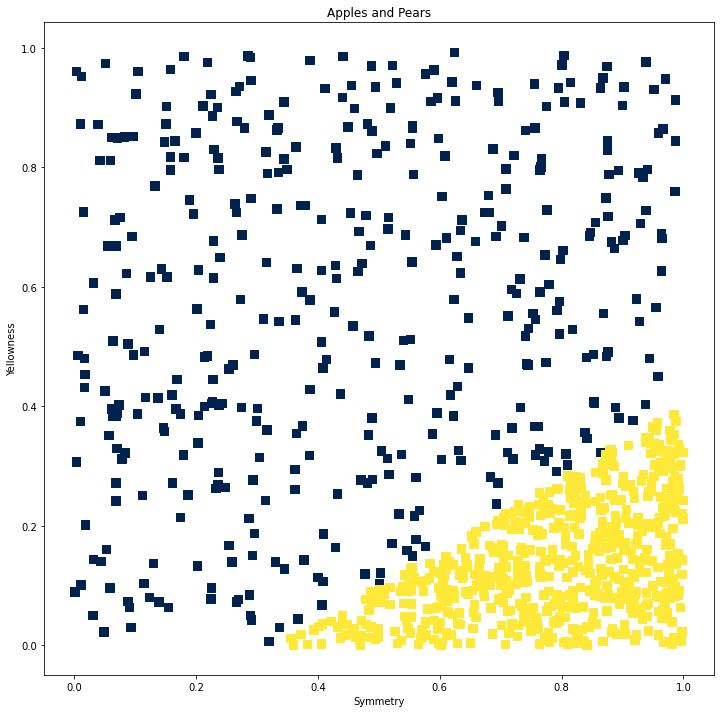

In [14]:
plot_ap(apples_pears.values, apples_pears.target)

#### Построение модели

In [15]:
x_train_ap, x_test_ap, y_train_ap, y_test_ap = train_test_split(
    apples_pears[['yellowness', 'symmetry']],
    apples_pears['target'],
    test_size=0.3)

x_train_ap = x_train_ap.values
y_train_ap = y_train_ap.values.reshape(-1, 1)
x_test_ap = x_test_ap.values
y_test_ap = y_test_ap.values.reshape(-1, 1)

In [16]:
%%time
model_ap = Neuron(learning_rate=0.1, epoch_number=50_000)
loss_values_ap = model_ap.fit(x_train_ap, y_train_ap)

CPU times: user 8.26 s, sys: 132 ms, total: 8.39 s
Wall time: 8.43 s


#### Построение графика функции потерь

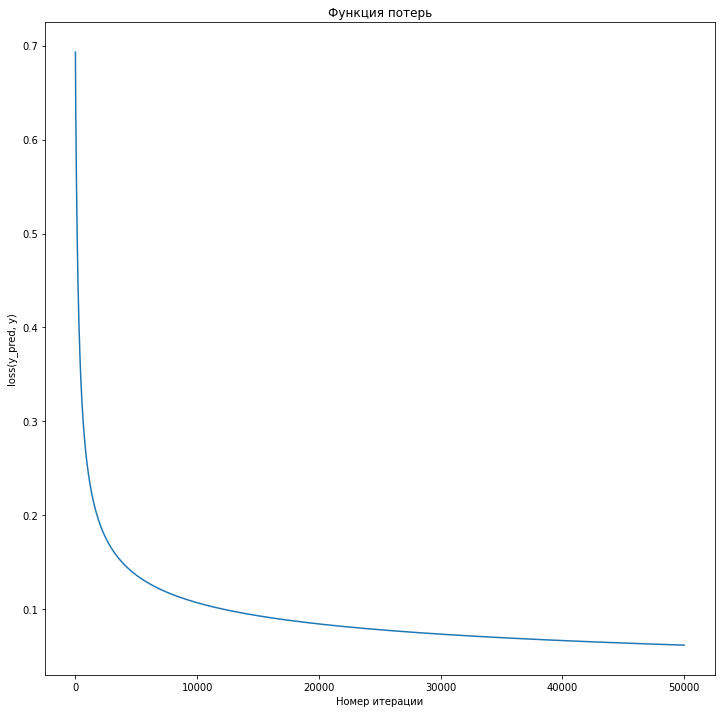

In [17]:
plot_loss_function(loss_values_ap)

#### Оценка наилучшего порогового значения для классификации

In [18]:
best_accuracy_ap, best_f1_ap = print_best_threshold(model_ap, x_test_ap, y_test_ap, np.arange(0.001, 1.001, 0.001))     

Best threshold for accuracy: 0.716 with accuracy = 1.0
Best threshold for f1: 0.716 with f1 = 1.0


#### Построение графика распределения с полученным наилучшим порогом

##### Accuracy

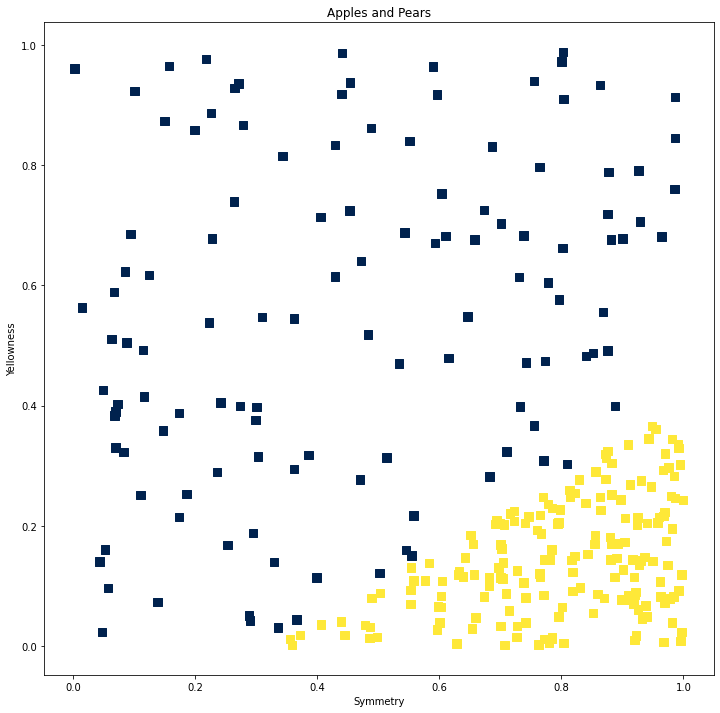

In [19]:
plot_ap(x_test_ap, model_ap.predict(x_test_ap, best_accuracy_ap[0]))

##### F1 Score

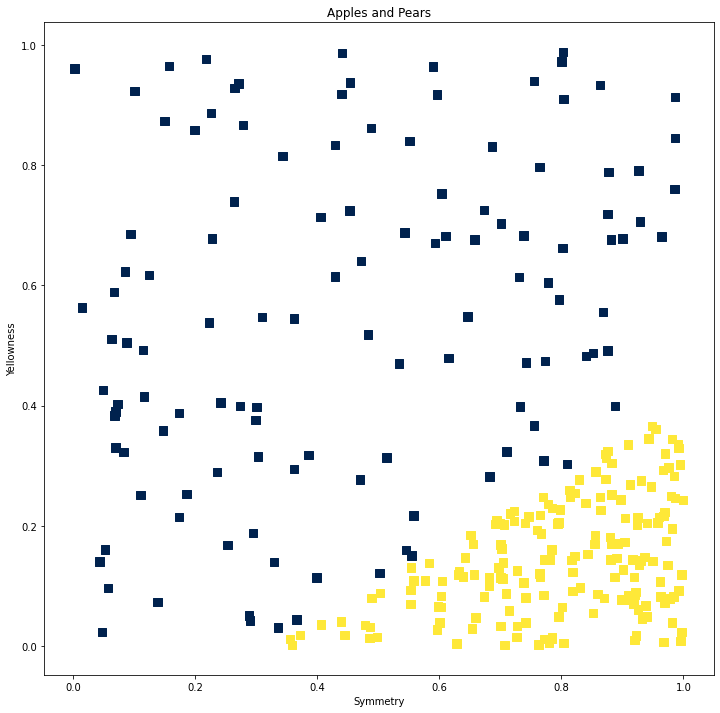

In [20]:
plot_ap(x_test_ap, model_ap.predict(x_test_ap, best_f1_ap[0]))

### Набор данных "голос"

#### Загрузка данных

In [21]:
!gdown 1_1YvZgUAgjKuRKPkkVnJlzQJy7rgkqBR

Downloading...
From: https://drive.google.com/uc?id=1_1YvZgUAgjKuRKPkkVnJlzQJy7rgkqBR
To: /content/voice.csv
100% 1.07M/1.07M [00:00<00:00, 122MB/s]


In [22]:
voice = pd.read_csv("voice.csv")
voice

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


#### Изменение label на {0, 1}

In [23]:
voice.replace({"label": {"female": 0, "male": 1}}, inplace=True)
voice

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,0
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,0
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,0
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,0


#### Использование MinMaxScaler

In [24]:
scaler = MinMaxScaler()

voice[voice.columns] = scaler.fit_transform(voice[voice.columns])
voice

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.096419,0.473409,0.084125,0.060063,0.204956,0.254828,0.367853,0.208279,0.635798,0.564526,...,0.096419,0.157706,0.030501,0.981526,0.000000,0.006452,0.000000,0.000000,0.000000,1.0
1,0.125828,0.505075,0.116900,0.077635,0.215683,0.246961,0.644279,0.483766,0.630964,0.591578,...,0.125828,0.287642,0.031140,0.834600,0.000407,0.006452,0.002144,0.002146,0.056449,1.0
2,0.179222,0.675536,0.102873,0.034284,0.385912,0.457148,0.885255,0.782275,0.442738,0.548382,...,0.179222,0.236945,0.030264,0.954963,0.000060,0.006452,0.000357,0.000358,0.049885,1.0
3,0.528261,0.554611,0.587559,0.389906,0.715802,0.407358,0.031549,0.001613,0.923261,0.856457,...,0.528261,0.183442,0.041287,0.834600,0.065659,0.006452,0.025375,0.025393,0.265043,1.0
4,0.452195,0.627209,0.454272,0.317627,0.707515,0.474474,0.027742,0.001732,0.958736,0.926348,...,0.452195,0.279190,0.036829,0.929285,0.238994,0.006452,0.250536,0.250715,0.223380,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.436911,0.684871,0.570361,0.198513,0.686256,0.577704,0.046854,0.003489,0.921665,0.901057,...,0.436911,0.698762,0.380813,0.904450,0.279703,0.006452,0.192280,0.192418,0.173674,0.0
3164,0.362946,0.731172,0.262871,0.171937,0.702595,0.621185,0.015961,0.000333,0.912549,0.834545,...,0.362946,0.732760,0.126776,0.981526,0.305791,0.075269,0.167977,0.166667,0.298053,0.0
3165,0.484949,0.799042,0.690337,0.134329,0.786967,0.742124,0.050161,0.003469,0.855587,0.765849,...,0.484949,0.847759,0.153011,0.981526,0.164908,0.006452,0.134024,0.134120,0.208885,0.0
3166,0.492516,0.745692,0.695311,0.175136,0.767804,0.681107,0.041908,0.002539,0.870307,0.792241,...,0.492516,0.641561,0.127158,0.834600,0.265621,0.006452,0.164046,0.164163,0.333559,0.0


#### Построение модели

In [25]:
x_train_v, x_test_v, y_train_v, y_test_v = train_test_split(
    voice.drop('label', axis=1),
    voice['label'],
    test_size=0.3)

x_train_v = x_train_v.values
y_train_v = y_train_v.values.reshape(-1, 1)
x_test_v = x_test_v.values
y_test_v = y_test_v.values.reshape(-1, 1)

In [26]:
%%time
model_v = Neuron(learning_rate=0.1, epoch_number=50_000)
loss_values_v = model_v.fit(x_train_v, y_train_v)

CPU times: user 33.5 s, sys: 29.2 s, total: 1min 2s
Wall time: 32.5 s


#### Построение графика функции потерь

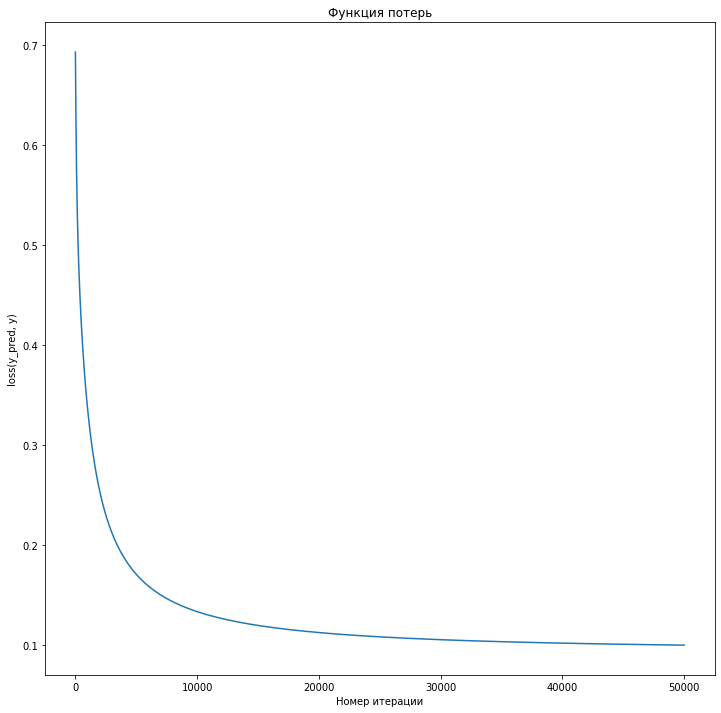

In [27]:
plot_loss_function(loss_values_v)

#### Оценка наилучшего порогового значения для классификации

In [28]:
best_accuracy_v, best_f1_v = print_best_threshold(model_v, x_test_v, y_test_v, np.arange(0.001, 1.001, 0.001)) 

Best threshold for accuracy: 0.56 with accuracy = 0.9726603575184016
Best threshold for f1: 0.56 with f1 = 0.9730290456431535
